In [1]:
import numpy as np
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from giae.so2.data import MNISTDataModule, MNISTDataset
from torch.utils.data import Dataset, DataLoader
from giae.so2.trainer import Trainer
from torchvision.transforms import RandomRotation, Pad, Resize, ToTensor, GaussianBlur
from PIL import Image
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
PATH_TO_MINST_TEST_SET = "mnist_all_rotation_normalized_float_test.amat"
PATH_TO_MODEL_CHECKPOINT = "mnist_saves/run1/last.ckpt"

In [3]:
ds = MNISTDataset(np.loadtxt(PATH_TO_MINST_TEST_SET))
dl = DataLoader(ds, batch_size=512)

In [4]:
device = "cuda:1"
model = Trainer.load_from_checkpoint(PATH_TO_MODEL_CHECKPOINT, strict=False).to(device)
model = model.eval()

inv model


/home/ggwaq/anaconda3/envs/a100_pt110/lib/python3.9/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/IndexingUtils.h:30.)
  full_mask[mask] = norms.to(torch.uint8)
/home/ggwaq/anaconda3/envs/a100_pt110/lib/python3.9/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1273.)
  full_mask[mask] = norms.to(torch.uint8)
/home/ggwaq/anaconda3/envs/a100_pt110/lib/python3.9/site-packages/pytorch_lightning/core/saving.py:208: UserWarning: Found keys that are in the model state dict but not in

In [5]:
resize1 = Resize(112)
resize2 = Resize(28)
totensor = ToTensor()
blur = GaussianBlur(kernel_size=3, sigma=(0.01, 0.01))

In [6]:
# GENERATE rotated versions. Resize to minimize interploation artifacts
i = 10
x, y =  ds[i]
x_r = Image.fromarray(x.numpy())
x_r = torch.cat((
    totensor(resize2(blur(x_r.rotate(0*90., Image.BILINEAR)))).reshape(1, 28, 28),
    totensor(resize2(blur(x_r.rotate(0.5*90., Image.BILINEAR)))).reshape(1, 28, 28),
    totensor(resize2(blur(x_r.rotate(1*90., Image.BILINEAR)))).reshape(1, 28, 28),
    totensor(resize2(blur(x_r.rotate(1.5*90., Image.BILINEAR)))).reshape(1, 28, 28),
    totensor(resize2(blur(x_r.rotate(2*90., Image.BILINEAR)))).reshape(1, 28, 28),
    totensor(resize2(blur(x_r.rotate(2.5*90., Image.BILINEAR)))).reshape(1, 28, 28),
    totensor(resize2(blur(x_r.rotate(3.*90., Image.BILINEAR)))).reshape(1, 28, 28),
    totensor(resize2(blur(x_r.rotate(3.5*90., Image.BILINEAR)))).reshape(1, 28, 28)), dim=0)
x_r.shape

torch.Size([8, 28, 28])

In [7]:
with torch.no_grad():
    y, rot, emb = model.model(x_r.to(device), do_rot=False)
    y2, rot, emb = model.model(x_r.to(device), do_rot=True)
    y = y.cpu().numpy()
    y2 = y2.cpu().numpy()
    rot = rot.cpu().numpy()

/home/ggwaq/anaconda3/envs/a100_pt110/lib/python3.9/site-packages/torch/nn/functional.py:3847: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


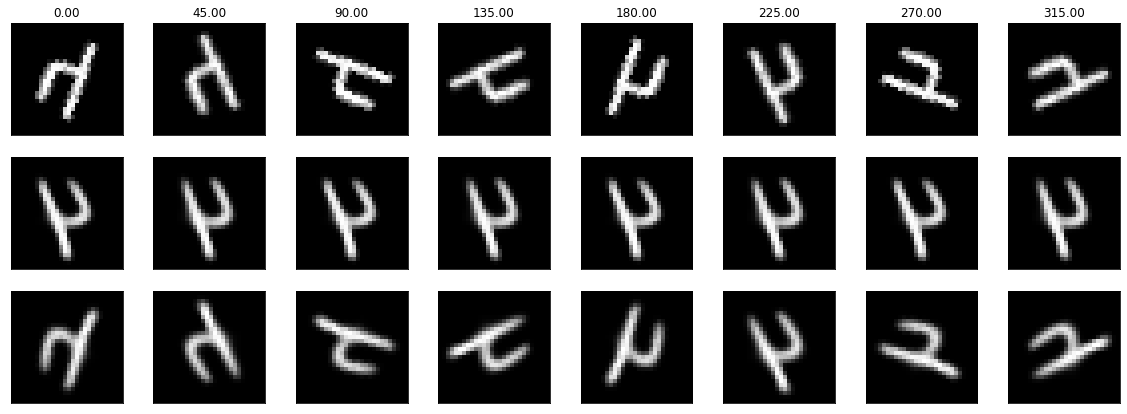

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=8, figsize=(20, 7))
theta = torch.Tensor([0, 0.5*90, 1*90, 1.5*90, 2*90, 2.5*90, 3*90, 3.5*90])
for i in range(len(theta)):
    ax[0, i].imshow(x_r[i], cmap="gray")
    ax[1, i].imshow(y[i, 0], cmap="gray")
    ax[2, i].imshow(y2[i, 0], cmap="gray")
    ax[0, i].set_title("%.2f" % (theta[i].numpy()))
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.show()

In [10]:
emb_list = []
y_list = []
with torch.no_grad():
    for x, y in iter(dl):
        emb, _ = model.model.encoder(x.to(device))
        emb_list.append(emb.cpu())
        y_list.append(y)
x_test = torch.cat(emb_list)
y_test = torch.cat(y_list)

In [11]:
emb = TSNE(2, perplexity=30).fit_transform(x_test)

/home/ggwaq/anaconda3/envs/a100_pt110/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ggwaq/anaconda3/envs/a100_pt110/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


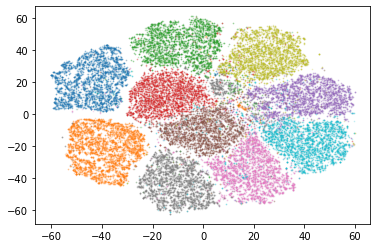

In [12]:
for i in range(10):
    plt.scatter(emb[y_test==i, 0], emb[y_test==i, 1], alpha=0.2, s=0.5, label=[i for i in range(10)][i])